In [1]:
import gym
import numpy as np, pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
import os
import logging
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel(logging.ERROR)

2
(4,)
[ 0.02705784 -0.0239745  -0.03692205 -0.01196095]


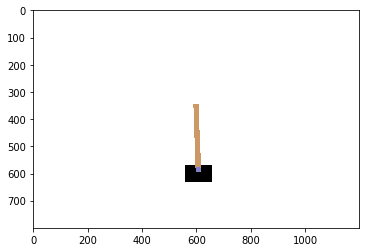

In [4]:
env = gym.make("CartPole-v0")


#gym compatibility: unwrap TimeLimit
if hasattr(env,'env'):
    env=env.env

x=env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape
print(n_actions)
print(state_dim)
print(x)

plt.imshow(env.render("rgb_array"))

# Building the policy network

In [5]:

#create input variables. We only need <s,a,R> for REINFORCE
states = tf.placeholder('float32',(None,)+state_dim,name="states")
actions = tf.placeholder('int32',name="action_ids")
cumulative_rewards = tf.placeholder('float32', name="cumulative_returns")

In [6]:
#<define network graph using raw tf or any deep learning library>
import tensorflow.keras.layers as L
Sequential = tf.keras.models.Sequential

network = Sequential()
network.add(L.Dense(32, activation='relu', input_shape=state_dim))
network.add(L.Dense(32, activation='relu'))
network.add(L.Dense(n_actions, activation='linear'))

logits = network(states)

#####################
policy = tf.nn.softmax(logits)
log_policy = tf.nn.log_softmax(logits)

In [7]:
#utility function to pick action in one given state
get_action_proba = lambda s: policy.eval({states:[s]})[0] 

#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


Following the REINFORCE algorithm, we can define our objective as follows: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [8]:
indices = tf.stack([tf.range(tf.shape(log_policy)[0]),actions],axis=-1)
log_policy_for_actions = tf.gather_nd(log_policy,indices)

J = tf.reduce_mean(log_policy_for_actions*cumulative_rewards)

#regularize with entropy
entropy =  -tf.reduce_sum(policy * log_policy, 1, name="entropy")

#weight updates. maximizing J is same as minimizing -J. Adding negative entropy.
loss = -J -0.1 * entropy

update = tf.train.AdamOptimizer().minimize(loss)

### Computing cumulative rewards

In [9]:
from collections import deque
def get_cumulative_rewards(rewards, #rewards at each step
                           gamma = 0.99 #discount for reward
                           ):
    """
    R_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
    """
    
    cumulative_rewards = deque([rewards[-1]])
    for i in range(len(rewards)-2, -1, -1):
        cumulative_rewards.appendleft(rewards[i]+gamma*cumulative_rewards[0])
        
    return cumulative_rewards
    
def train_step(_states,_actions,_rewards):
    """given full session, trains agent with policy gradient"""
    _cumulative_rewards = get_cumulative_rewards(_rewards)
    update.run({states:_states,actions:_actions,cumulative_rewards:_cumulative_rewards})    

### Playing the game

In [10]:
def generate_session(t_max=1000):
    """play env with REINFORCE agent and train at the session end"""
    
    #arrays to record session
    states,actions,rewards = [],[],[]
    
    s = env.reset()
    
    for t in range(t_max):
        
        #action probabilities array aka pi(a|s)
        action_probas = get_action_proba(s)
        
        a = np.random.choice(n_actions, 1, p=action_probas)[0]
        
        new_s,r,done,info = env.step(a)
        
        #record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)
        
        s = new_s
        if done: break
            
    train_step(states,actions,rewards)
            
    return sum(rewards)
        

In [11]:
s = tf.InteractiveSession()
s.run(tf.global_variables_initializer())

for i in range(100):
    
    rewards = [generate_session() for _ in range(100)] #generate new sessions
    
    print ("mean reward:%.3f"%(np.mean(rewards)))

    if np.mean(rewards) > 300:
        print ("Trained!")
        break
        


mean reward:35.480
mean reward:85.760
mean reward:226.040
mean reward:366.340
Trained!


### Results & video

In [12]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) 